In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import time

In [2]:
config InlineBackend.figure_format ='retina'

In [3]:
run  /Users/adrianovaldesgomez/Repos/PhD-Thesis/py/phd_python_documented_code.py

### Reading HDF5 files

In [ ]:
with h5py.File('pos_array.h5', 'r') as hf:
    keys = list(hf.keys())
    data = hf[keys[0]][:]

### Filling a list of position vectors

In [ ]:
l_pos_t = [[v for v in data[i]] for i in range(data.shape[0])]

### Functions for statistical analysis

In [ ]:
def thetas_phis_ensemble(l_pos_t):
    """This function returns two lists of the ensemble of angular coordinates 
    given a list of position vactors"""

    thetas_ensamble = []
    phis_ensamble = []
    for l_pos in l_pos_t:
        thetas = []
        phis = []
        for pos in l_pos:
            r, theta, phi = trans_c_s(pos[0],pos[1],pos[2])
            thetas.append(theta)
            phis.append(phi)

        thetas_ensamble.append(thetas)
        phis_ensamble.append(phis)
    return thetas_ensamble, phis_ensamble


### Loading angle ensembles

In [ ]:
thetas_ensamble, phis_ensamble = thetas_phis_ensemble(l_pos_t)

### Converting to array

In [ ]:
t_ens_array, p_ens_array = np.array(thetas_ensamble), np.array(phis_ensamble)

### Time array

In [33]:
def time_array(MC_steps, dt):
    tiempos = [0]
    suma = 0
    for i in range(MC_steps):
        suma += dt
        tiempos.append(suma)
    return np.array(tiempos)

### Generating time array

In [36]:
t_a = time_array(10000,np.log(2)*1e-3)

## We need to calculate the first moments of the distribution

We will calculate analytically, though we will have to do some numeric integrations using the Simpson method for some cases, the $\langle \theta^n(t) \rangle$ for $n=1,2,3,4$, as well as $\theta_{max}$ such that $P(\theta_{max}) \ge P(\theta)$ for all $\theta \in [0,\pi]$

### The mean

In [4]:
from scipy import integrate

### Normalization Constant

In [8]:
NY20 = integrate.simps(Y20(thetas,1., 5.0*np.sqrt(2*D)/D), thetas)

In [52]:
NY20

64730.73128110564

In [9]:
cy20 = -np.sqrt((5./(16*np.pi)))
def Y20(theta,N,u0_gamma):
    return np.exp(- u0_gamma * cy20 * (3 * np.cos(theta)**2 - 1)) * np.sin(theta) / N

In [6]:
D = .1

In [7]:
thetas = np.linspace(0,np.pi,1000000)
phis = np.linspace(0,2*np.pi,2000000)

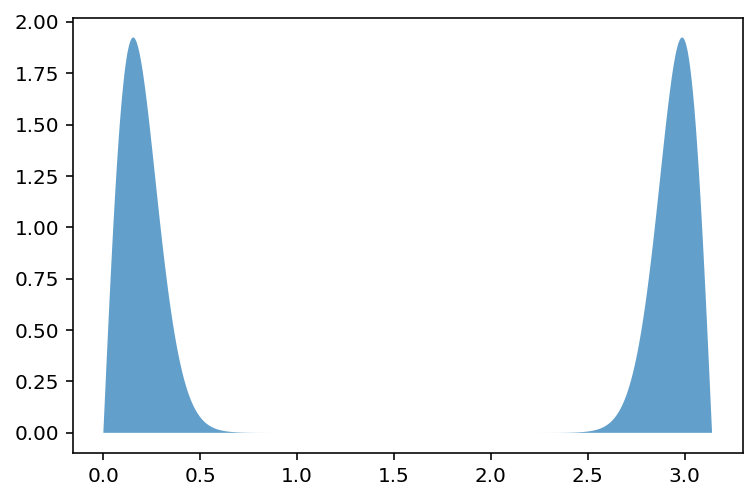

In [12]:
plt.fill_between(thetas, Y20(thetas, NY20, 5.0*np.sqrt(2*D)/D), alpha=0.7)

In [13]:
theta_mean_y20 = integrate.simps(thetas * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [21]:
theta_mean_y20

1.5707963267948966

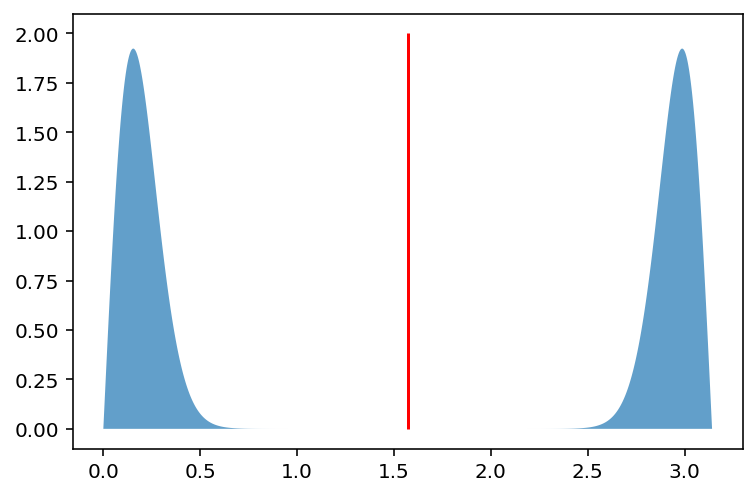

In [14]:
plt.fill_between(thetas, Y20(thetas, NY20, 5.0*np.sqrt(2*D)/D), alpha=0.7)
plt.vlines(theta_mean_y20, 0,2, color='r')

### The second moment

In [15]:
theta_2nd_m_y20 = integrate.simps(thetas**2 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [19]:
theta_2nd_m_y20

4.363844635608555

### The variance

In [18]:
theta_var_y20 = integrate.simps((thetas - theta_mean_y20)**2 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [20]:
theta_var_y20

1.8964435353362155

In [22]:
theta_2nd_m_y20 - theta_mean_y20**2

1.896443535336216

### The third moment

In [16]:
theta_3nd_m_y20 = integrate.simps(thetas**3 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [49]:
theta_3nd_m_y20

12.812564202877644

### The forth moment

In [17]:
theta_4nd_m_y20 = integrate.simps(thetas**4 * Y20(thetas,1,5.0*np.sqrt(2*D)/D)/NY20, thetas)

In [43]:
theta_4nd_m_y20

37.84008818710703

## Loading Numerical results

In [23]:
pwd

'/Users/adrianovaldesgomez/Documents/Adriano_Programming'

In [45]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test02-N10000-D1e-1-dt1e-3/'

In [26]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [28]:
type(hist_thetas)

numpy.ndarray

In [29]:
hist_thetas.shape

(10001, 10000)

In [31]:
l_4th_m_t = []
for ensemble in hist_thetas:
    fourth_m = ensemble**4
    l_4th_m_t.append(fourth_m)

In [41]:
forth_m_a_t = np.array(l_4th_m_t).mean(axis=1)

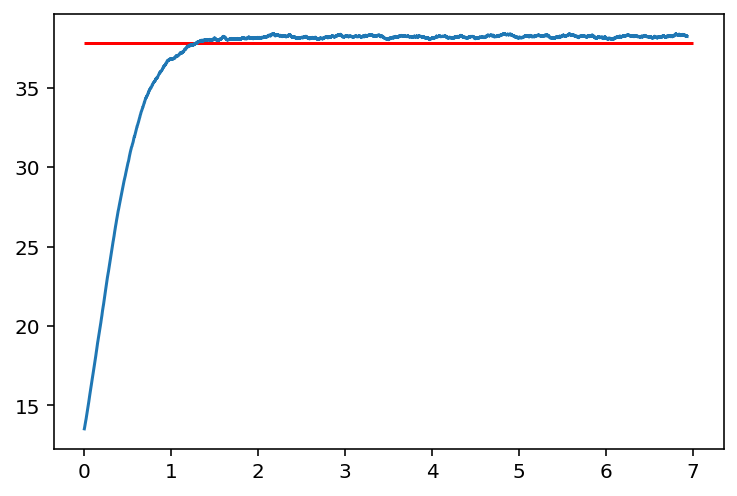

In [62]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [46]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-3_N10000.txt", forth_m_a_t)

In [47]:
l_3th_m_t = []
for ensemble in hist_thetas:
    thirth_m = ensemble**3
    l_3th_m_t.append(thirth_m)

In [48]:
thirth_m_a_t = np.array(l_3th_m_t).mean(axis=1)

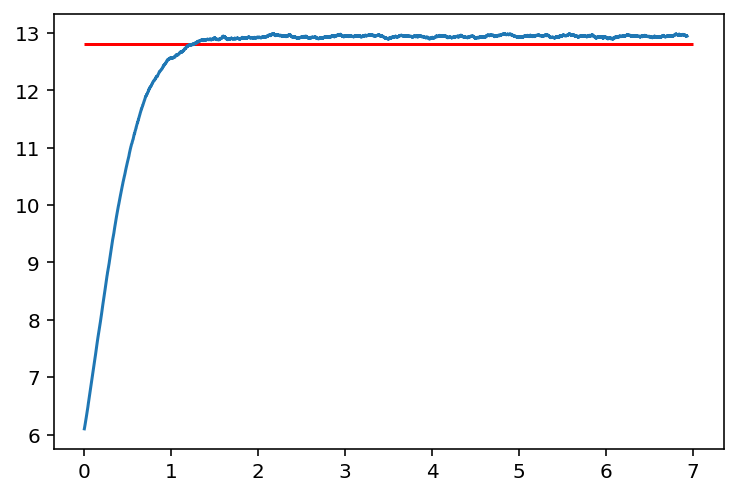

In [61]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [51]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-3_N10000.txt", thirth_m_a_t)

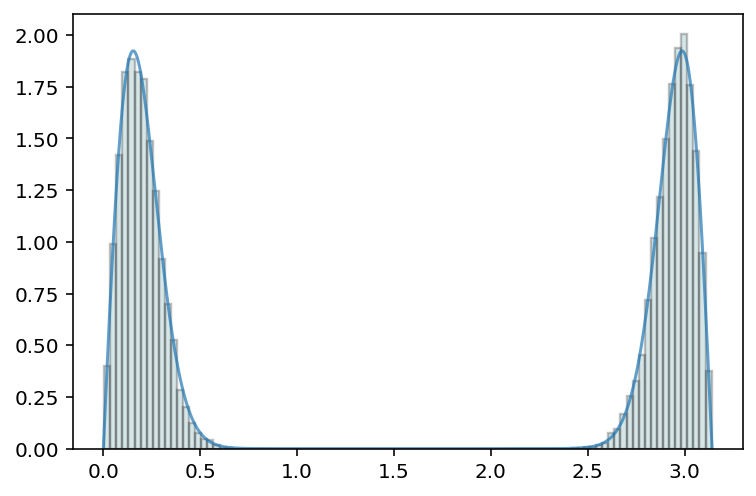

In [73]:
plt.plot(thetas, Y20(thetas, NY20, 5.0*np.sqrt(2*D)/D), alpha=0.7)
plt.hist(hist_thetas[-2], density=True, bins=100, alpha=.25, color = 'cadetblue',
        edgecolor='black', linewidth=1.2);

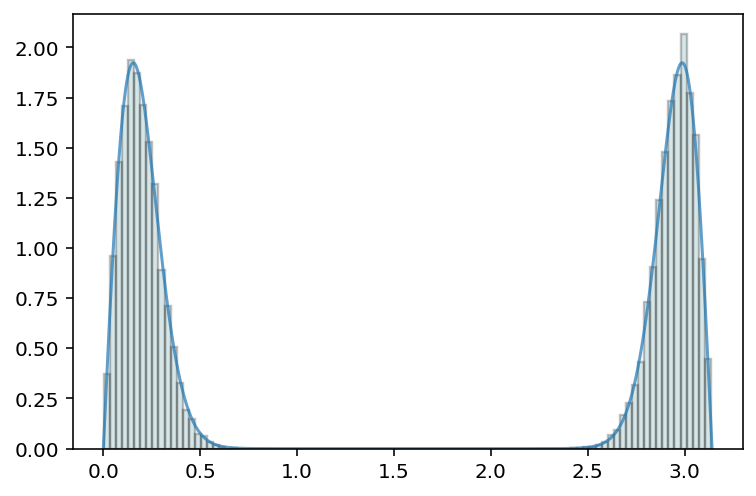

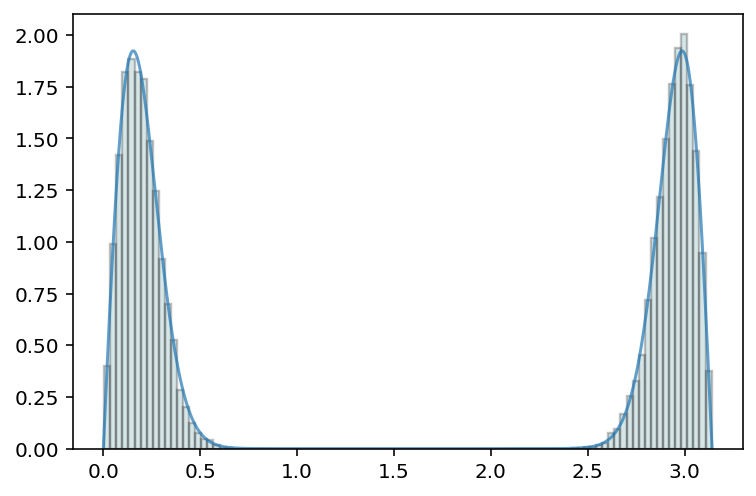

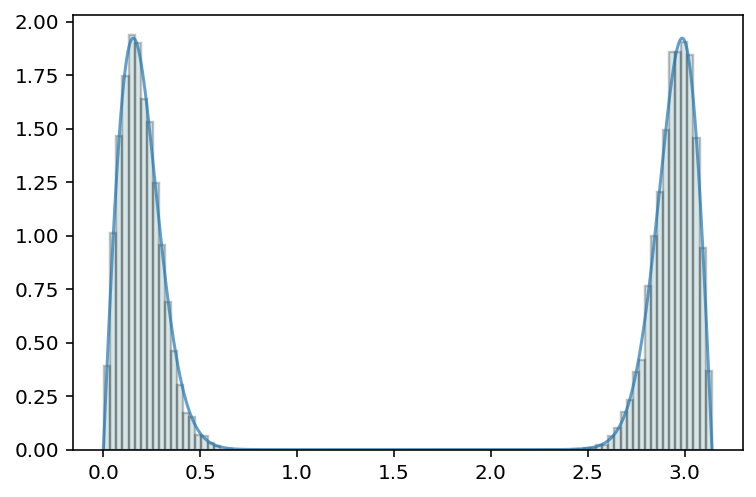

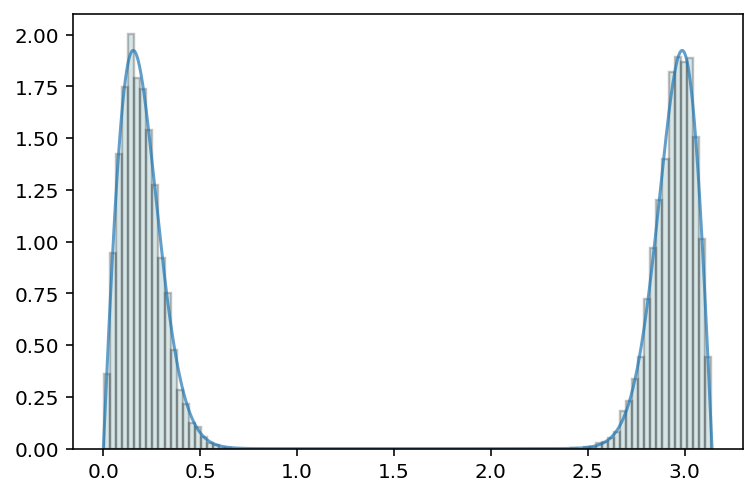

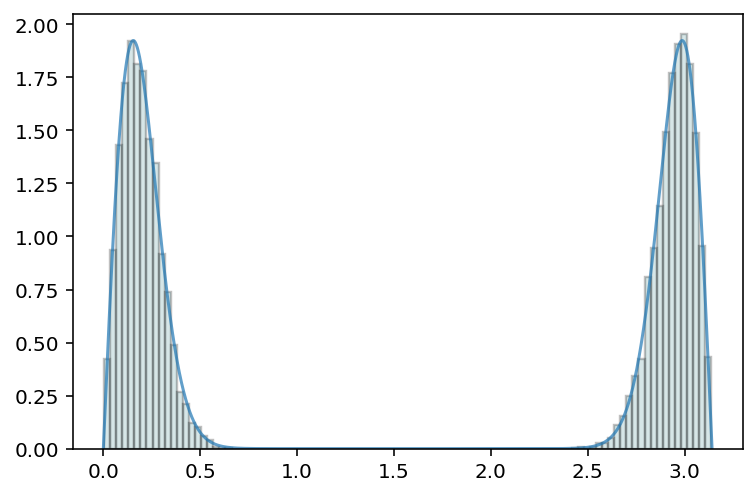

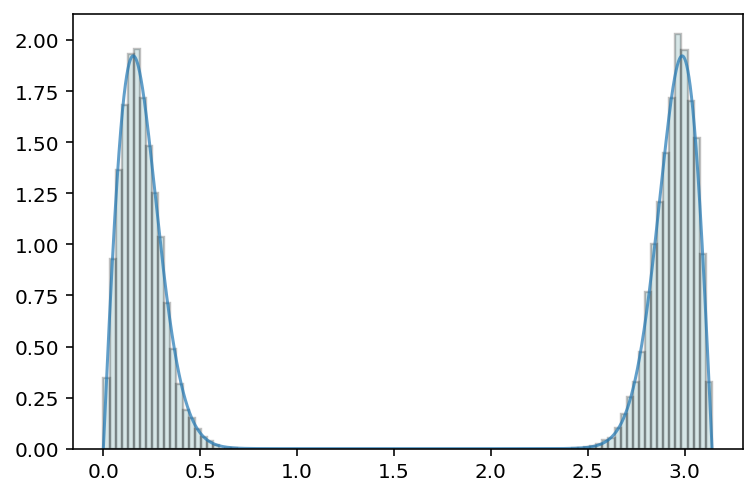

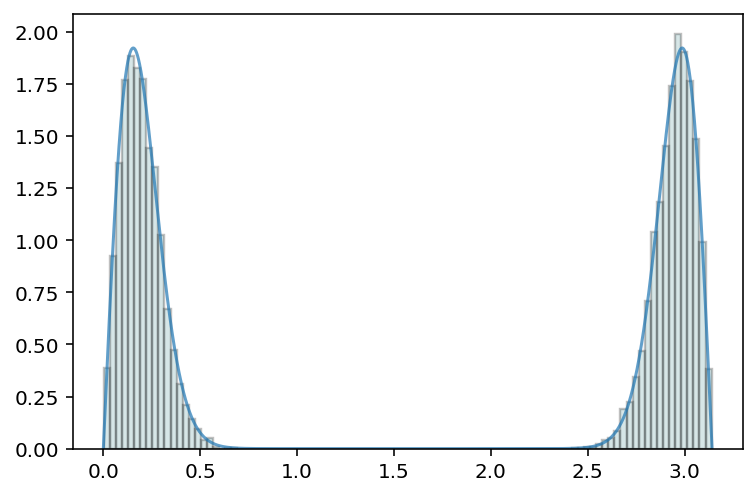

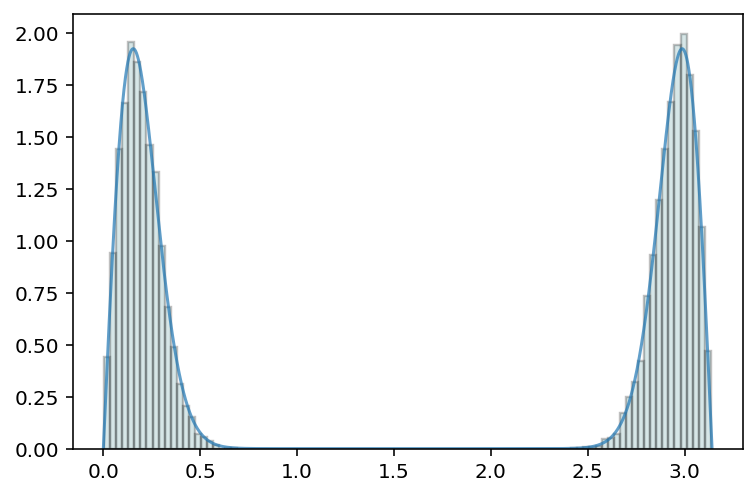

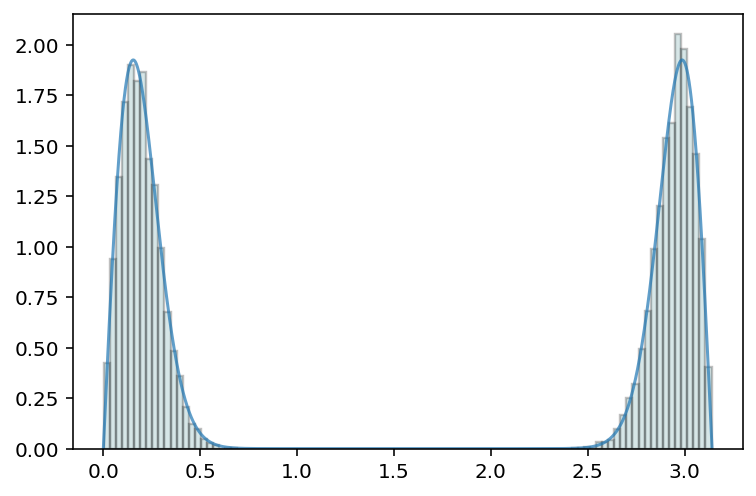

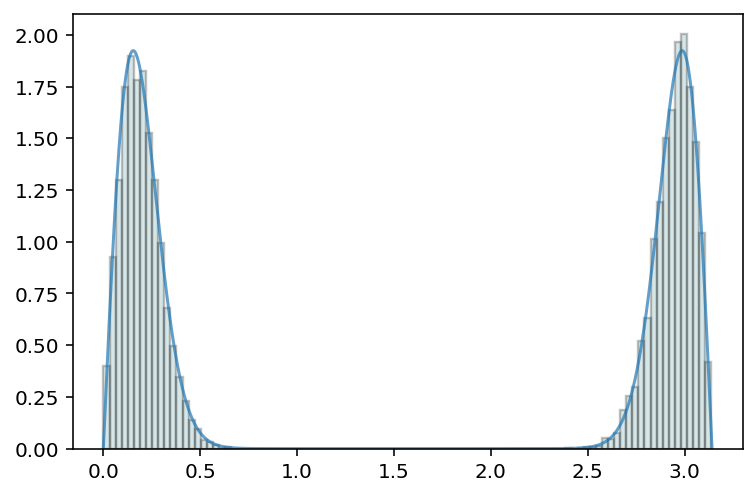

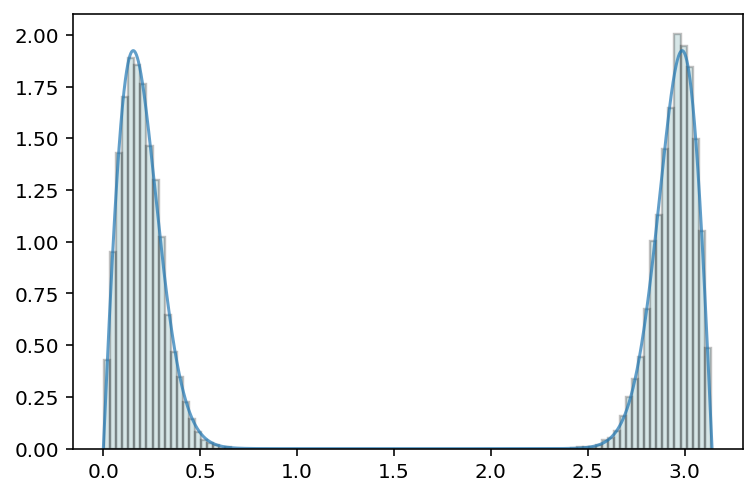

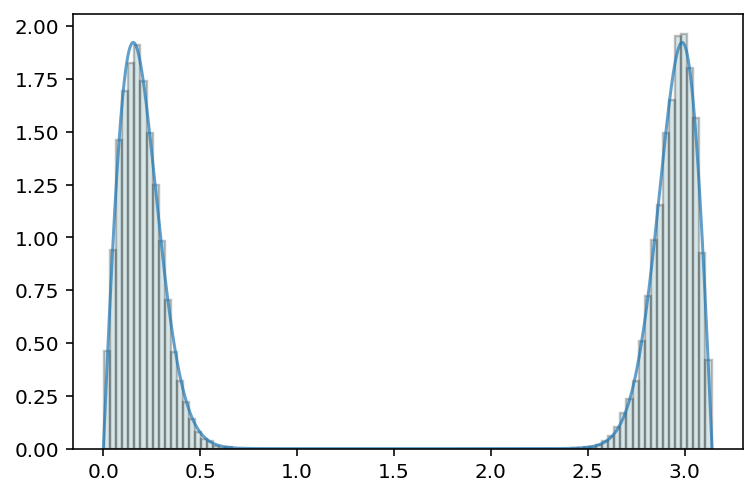

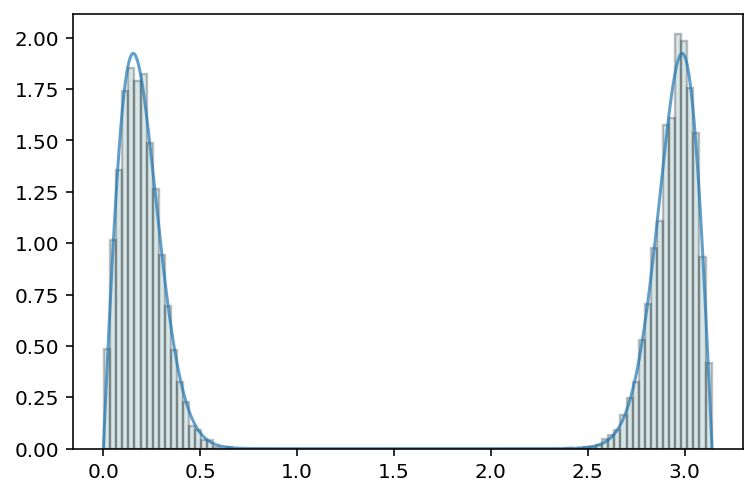

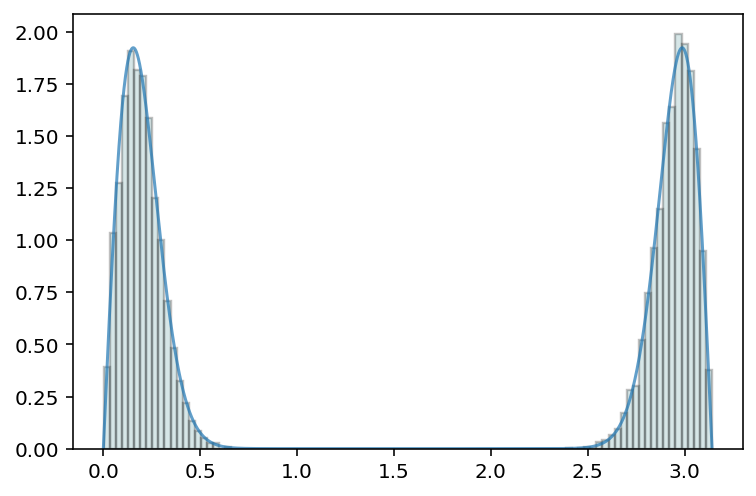

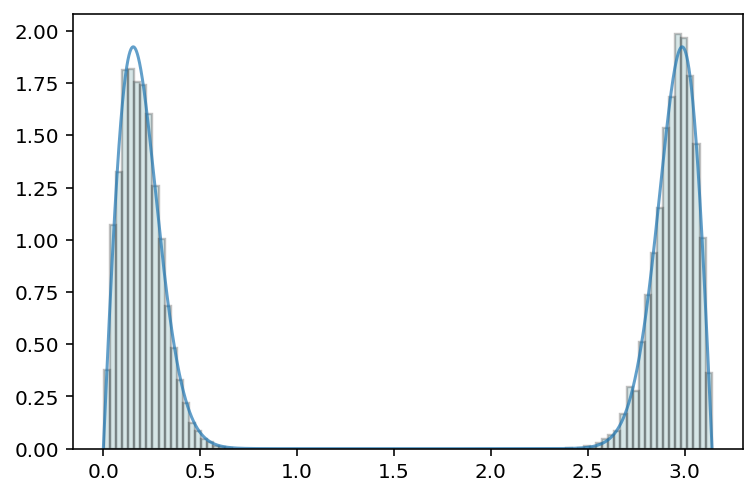

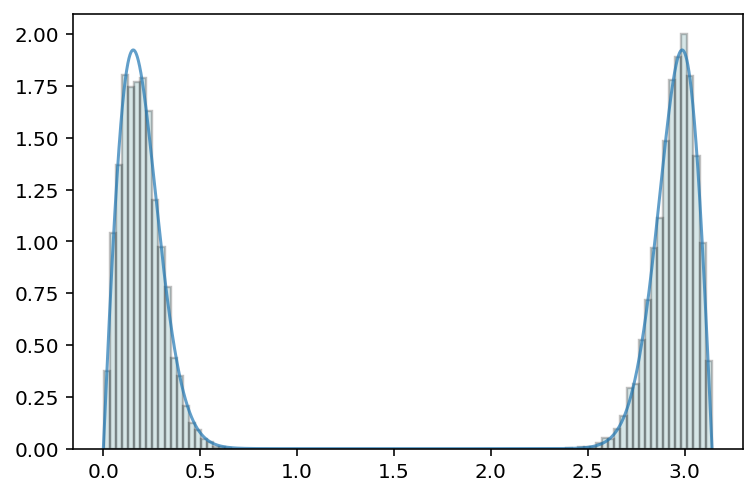

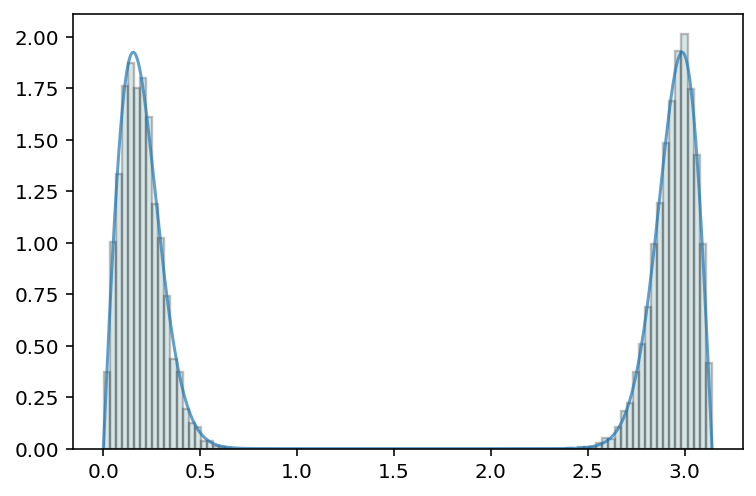

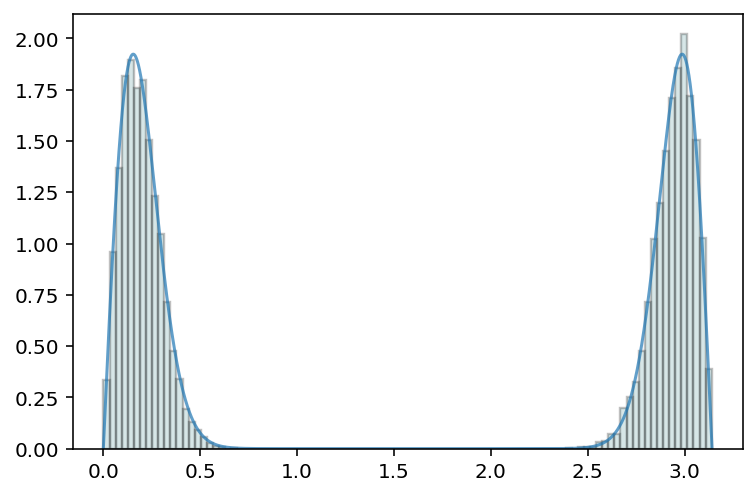

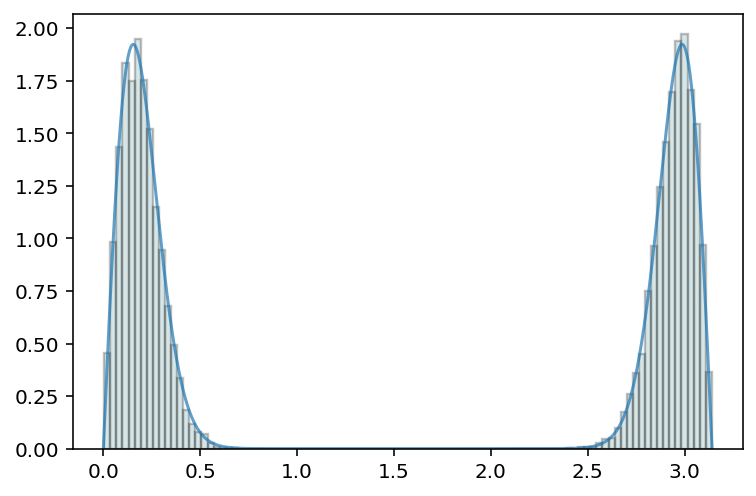

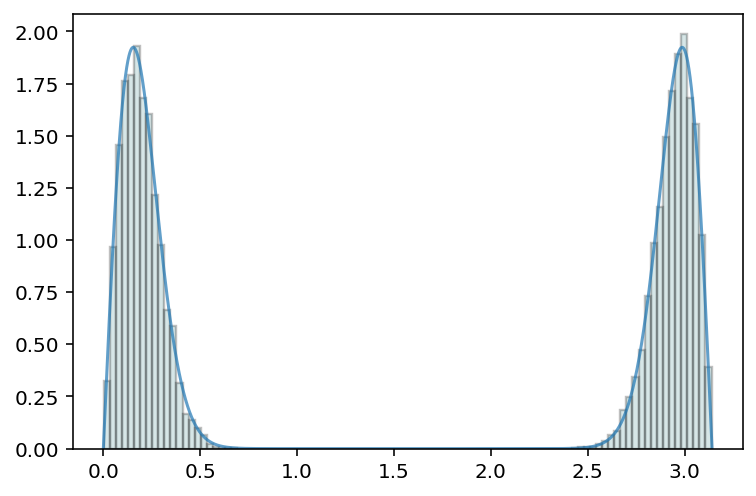

In [75]:
for n in [i for i in range(1,21)]:
    fig = plt.figure()
    plt.plot(thetas, Y20(thetas, NY20, 5.0*np.sqrt(2*D)/D), alpha=0.7)
    plt.hist(hist_thetas[-n], density=True, bins=100, alpha=.25, color = 'cadetblue',
        edgecolor='black', linewidth=1.2);

In [63]:
theta_mean_t = np.loadtxt(path + "Y20_Mean_Theta_t2.txt")

In [64]:
theta_var_t = np.loadtxt(path + "Y20_Var_Theta_t2.txt")

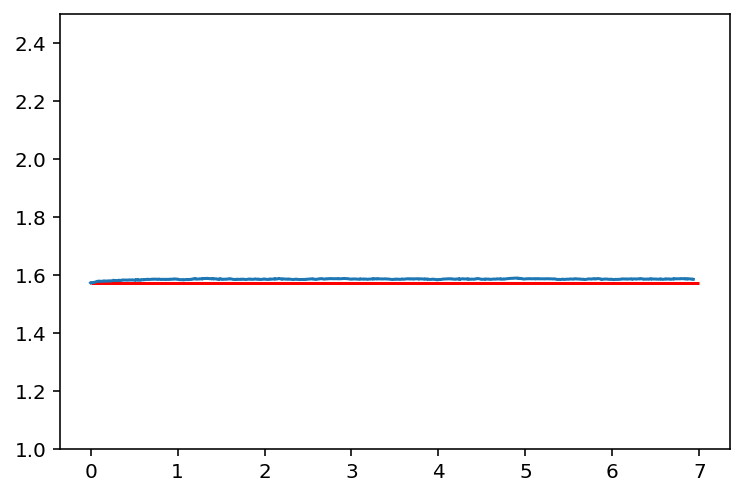

In [69]:
plt.plot(t_a, theta_mean_t)
plt.hlines(theta_mean_y20,0,7, color='r')
plt.ylim(1,2.5);

In [71]:
theta_mean_y20

1.5707963267948966

In [72]:
np.pi/2

1.5707963267948966

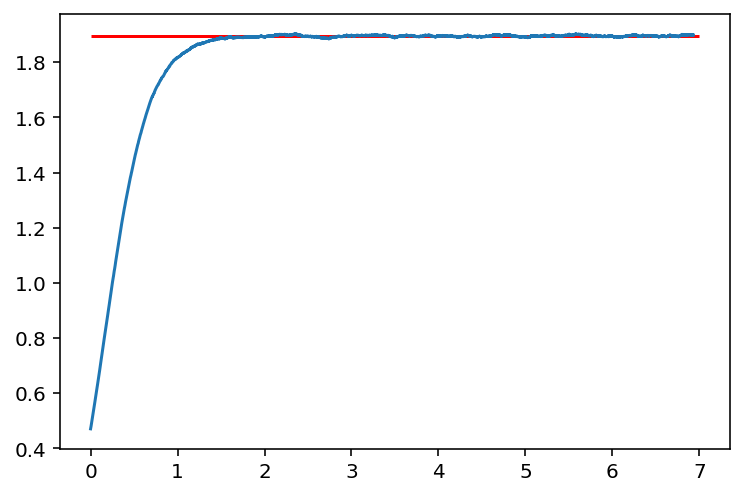

In [70]:
plt.plot(t_a, theta_var_t)
plt.hlines(theta_var_y20,0,7, color='r');
#plt.ylim(1,2.5);

In [76]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test03-N10000-D1e-1-dt1e-2/'

In [77]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [78]:
def calc_4th_m(hist):
    l_4th_m_t = []
    for ensemble in hist:
        fourth_m = ensemble**4
        l_4th_m_t.append(fourth_m)
    return np.array(l_4th_m_t).mean(axis=1)

In [79]:
forth_m_a_t = calc_4th_m(hist_thetas)

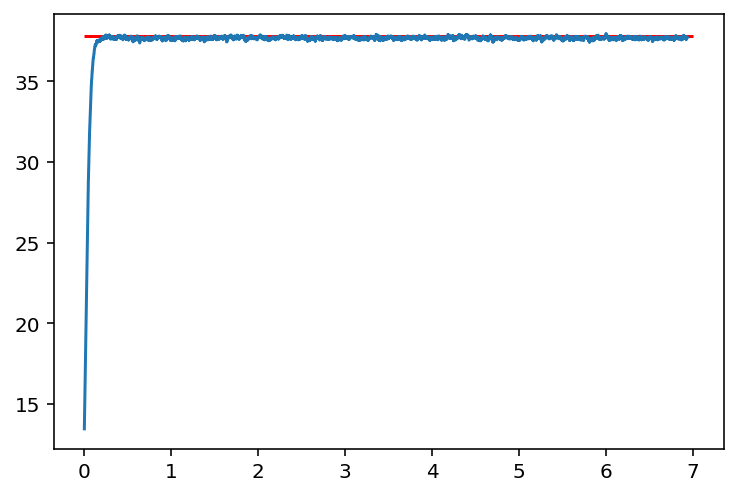

In [80]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [81]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-2_N10000.txt", forth_m_a_t)

In [82]:
def calc_3th_m_(hist):
    l_3th_m_t = []
    for ensemble in hist:
        thirth_m = ensemble**3
        l_3th_m_t.append(thirth_m)
    return np.array(l_3th_m_t).mean(axis=1)

In [83]:
thirth_m_a_t = calc_3th_m_(hist_thetas)

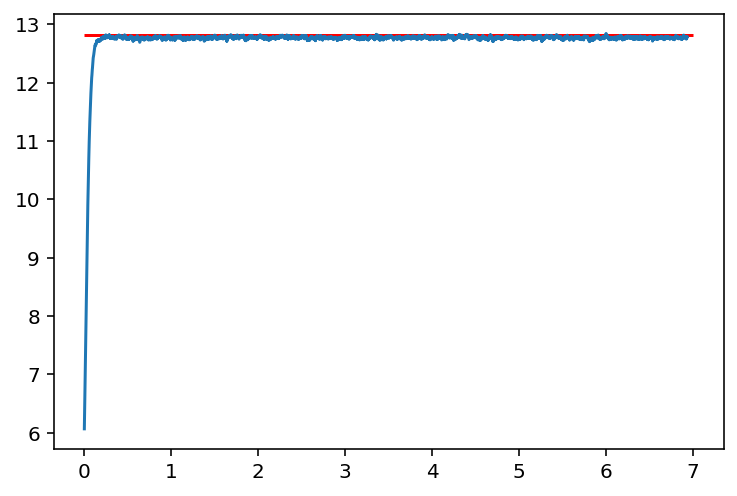

In [84]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [85]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-2_N10000.txt", thirth_m_a_t)

In [88]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test04-N10000-D1e-1-dt1e-1/'

In [89]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [90]:
forth_m_a_t = calc_4th_m(hist_thetas)

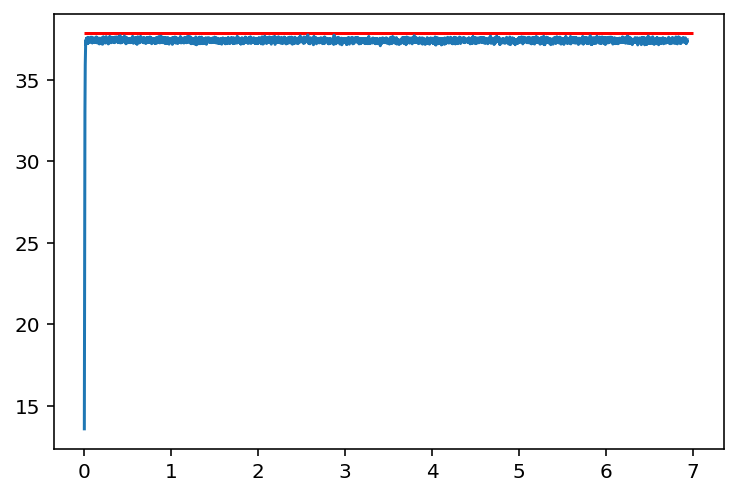

In [91]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [92]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-1_N10000.txt", forth_m_a_t)

In [93]:
thirth_m_a_t = calc_3th_m_(hist_thetas)

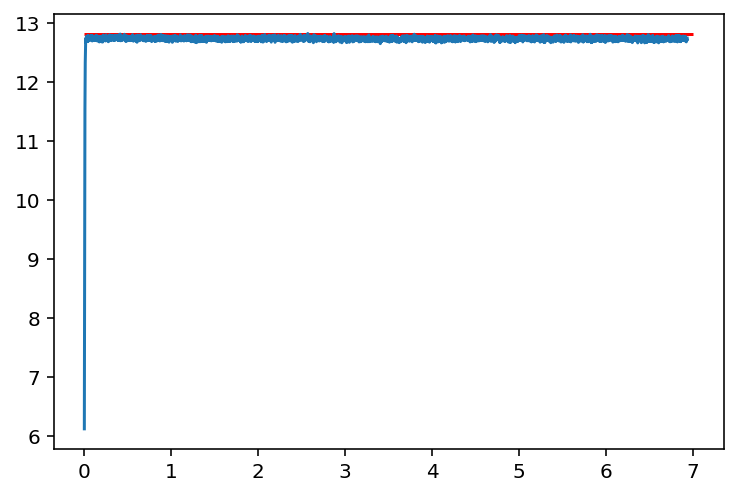

In [94]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [95]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-1_N10000.txt", thirth_m_a_t)

In [98]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test05-N1000-D1e-1-dt1e-1/'

In [99]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [100]:
forth_m_a_t = calc_4th_m(hist_thetas)

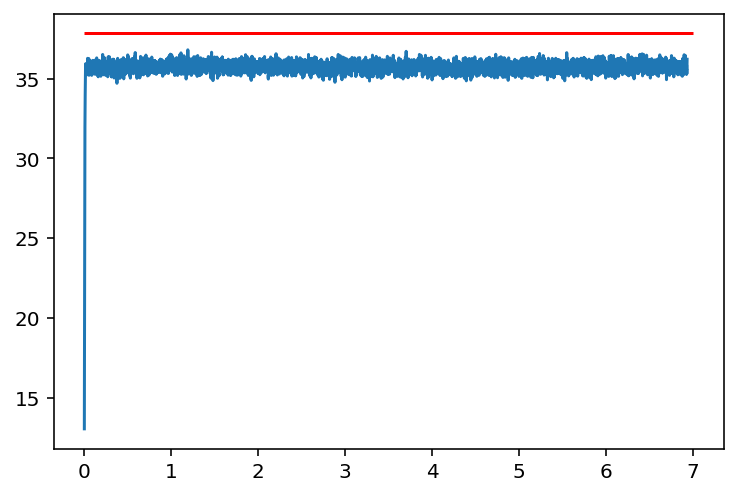

In [101]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [105]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-1_N1000.txt", forth_m_a_t)

In [103]:
thirth_m_a_t = calc_3th_m_(hist_thetas)

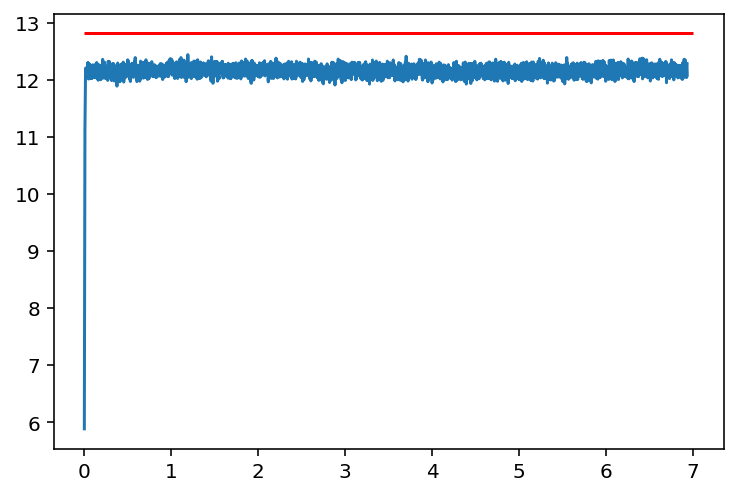

In [104]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [106]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-1_N1000.txt", thirth_m_a_t)

In [107]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test06-N1000-D1e-1-dt1e-2/'

In [108]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [109]:
forth_m_a_t = calc_4th_m(hist_thetas)

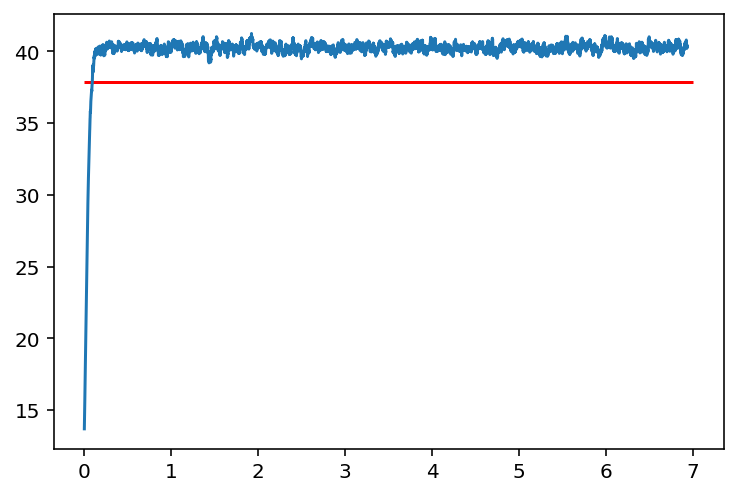

In [110]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [112]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-2_N1000.txt", forth_m_a_t)

In [111]:
thirth_m_a_t = calc_3th_m_(hist_thetas)

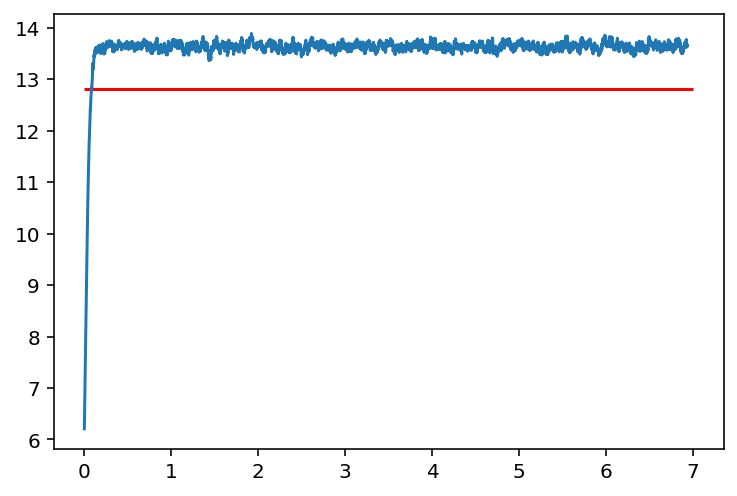

In [113]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [114]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-2_N1000.txt", thirth_m_a_t)

In [115]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test07-N1000-D1e-1-dt1e-3/'

In [116]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [117]:
forth_m_a_t = calc_4th_m(hist_thetas)

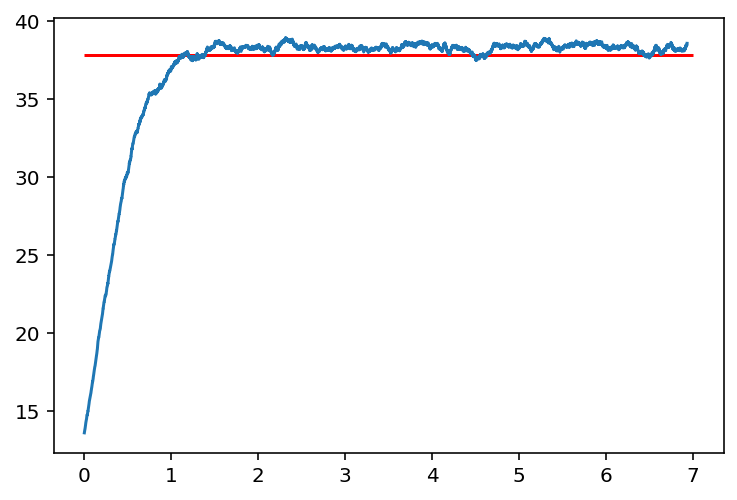

In [118]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [121]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-3_N1000.txt", forth_m_a_t)

In [119]:
thirth_m_a_t = calc_3th_m_(hist_thetas)

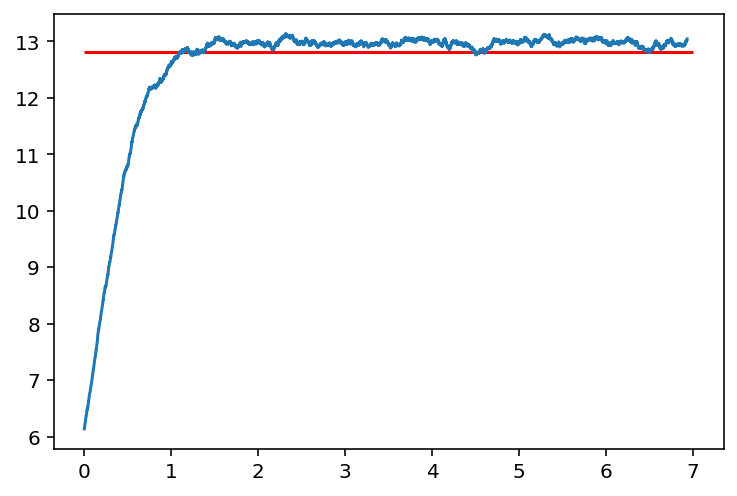

In [120]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [122]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-3_N1000.txt", thirth_m_a_t)

In [123]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test08-N100-D1e-1-dt1e-3/'

In [124]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [125]:
forth_m_a_t = calc_4th_m(hist_thetas)

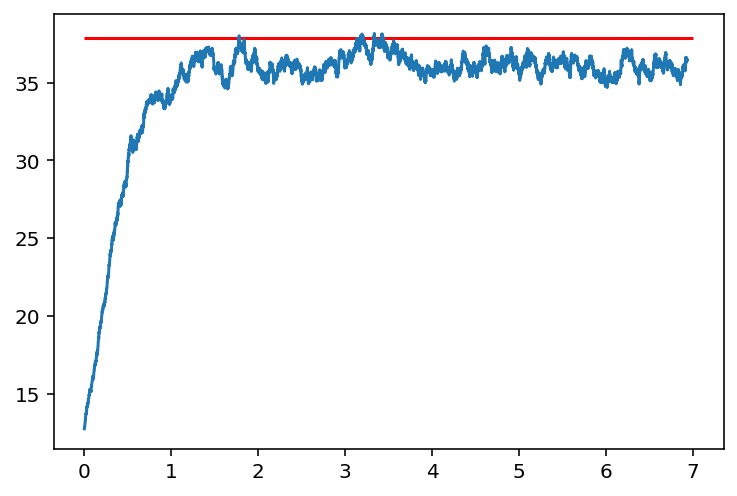

In [126]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [127]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-3_N100.txt", forth_m_a_t)

In [128]:
thirth_m_a_t = calc_3th_m_(hist_thetas)

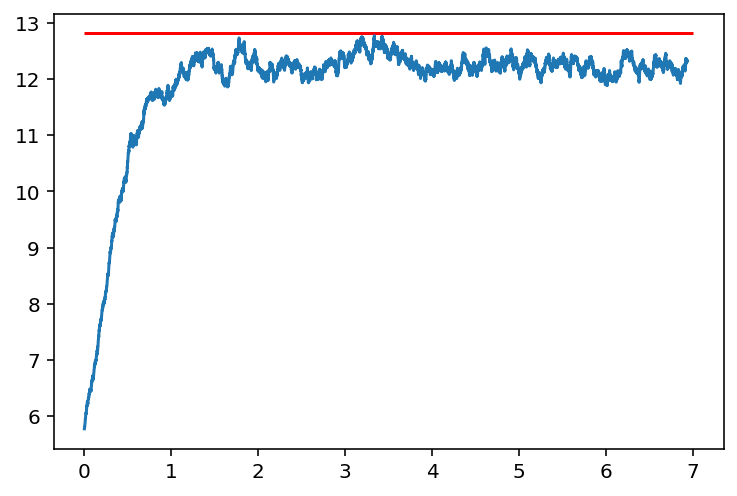

In [129]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [130]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-3_N100.txt", thirth_m_a_t)

In [131]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test09-N100-D1e-1-dt1e-2/'

In [132]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [133]:
forth_m_a_t = calc_4th_m(hist_thetas)

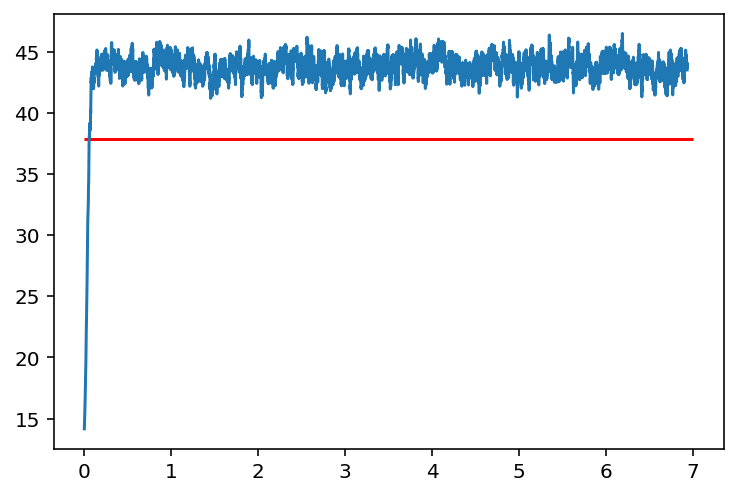

In [134]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

In [135]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-2_N100.txt", forth_m_a_t)

In [136]:
thirth_m_a_t = calc_3th_m_(hist_thetas)

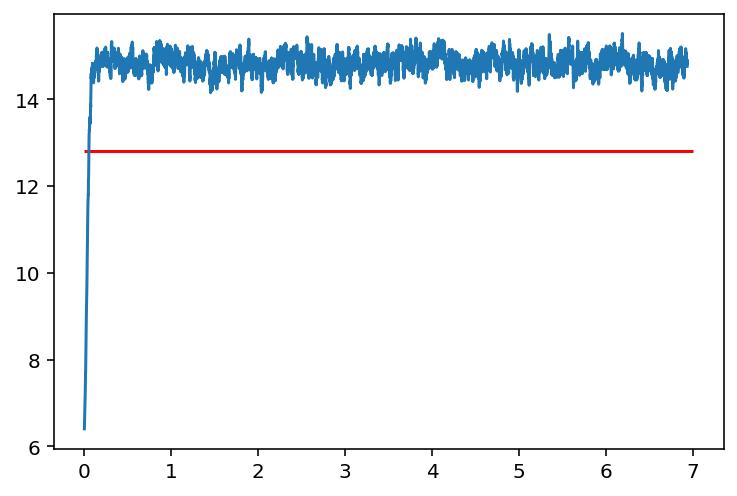

In [137]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [138]:
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-2_N100.txt", thirth_m_a_t)

In [139]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test10-N100-D1e-1-dt1e-1/'

In [140]:
hist_thetas = np.loadtxt(path + "Y20UD_Hist_Theta_t.txt")

In [141]:
forth_m_a_t = calc_4th_m(hist_thetas)
thirth_m_a_t = calc_3th_m_(hist_thetas)

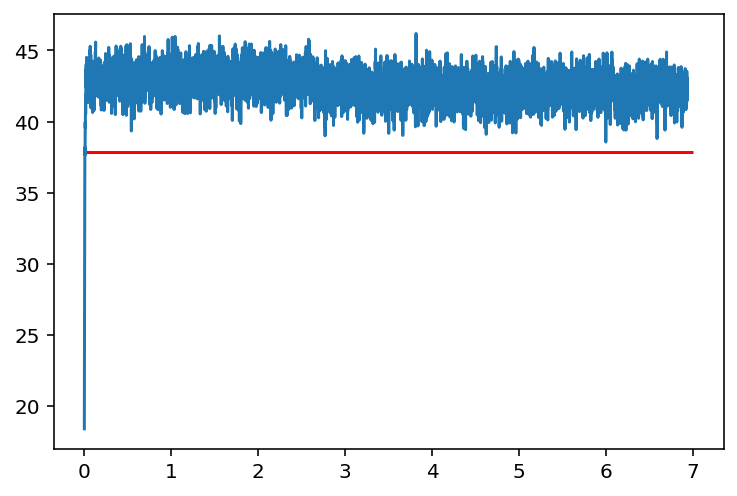

In [142]:
plt.plot(t_a, forth_m_a_t)
plt.hlines(theta_4nd_m_y20,0,7, color='r');

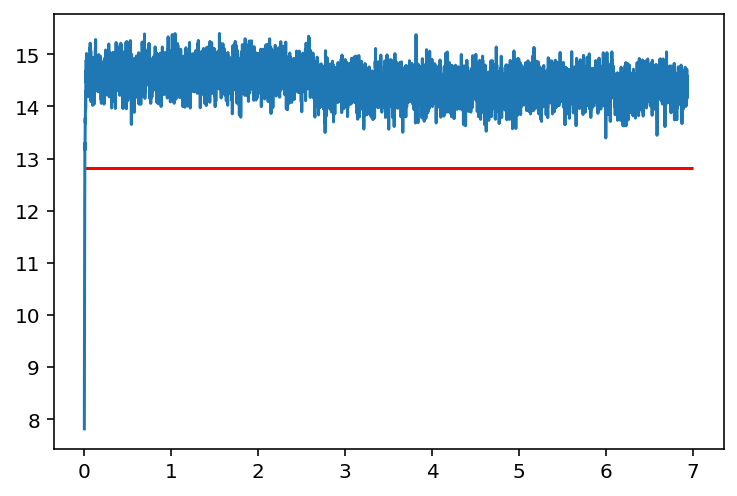

In [143]:
plt.plot(t_a, thirth_m_a_t)
plt.hlines(theta_3nd_m_y20,0,7, color='r');

In [144]:
np.savetxt(path + "Y20_ST_4th_M_t_D1e-1_dt_1e-1_N100.txt", forth_m_a_t)
np.savetxt(path + "Y20_ST_3th_M_t_D1e-1_dt_1e-1_N100.txt", thirth_m_a_t)

### Calculating mean absolute error for $\theta$

In [ ]:
theta_mean_t = t_ens_array.mean(axis=1)
theta_var_t = t_ens_array.var(axis=1)

Estimation
\begin{align}
\overline{f(t)} = \frac{1}{\tau} \int_{t_{min}}^{t_{min} + \tau} f (\xi)\, d \xi = \frac{1}{m} \sum_{k=1}^{m} f(t_{k})
\end{align}
Where
\begin{align}
t_{min} = \min{\left \{ t \in [0,T] | f(t) = \langle f \rangle \right \}}
\end{align}
and $\tau = [t_{min}, T]$, where $T = \mbox{MC_steps} \times dt$
​
Non-equilibrium time average with respect the equilibrium average
\begin{align}
\overline{\Delta f(t)} = f(t) - \langle f \rangle
\end{align}


### Index Function

In [ ]:
#def find_index_autocorr(auto_t):
#    for i in range(auto_t.shape[0]):
#        if auto_t[i] <= 0.:
#            return i

In [ ]:
#def mean_abs_errr_auto(auto_t):
#    idx = find_index_autocorr(auto_t)
#    abs_auto_t = abs(auto_t[idx:])
#    return abs_auto_t.mean()

This is crucial: As the mean value for the initial distribution (the uniform distribution on $\mathbb{S}^2$) is the same as the mean of the stationary distribution, we will use the index for which the variance reaches is stationary value for the first time

In [ ]:
#def find_index_mean(mean_t):
#    for i in range(mean_t.shape[0]):
#        if mean_t[i] >= np.pi/2:
#            return i

In [154]:
def find_index_var(var_t):
    for i in range(var_t.shape[0]):
        if var_t[i] >= theta_var_y20:
            return i

### We have to calculate the mean value

In [157]:
def mean_abs_err_mean(mean_t):
    idx = idx_var
    abs_mean_e_t = abs(mean_t[idx:] - np.pi/2*np.ones(mean_t[idx:].shape[0]))
    return abs_mean_e_t.mean()

In [158]:
def mean_abs_err_var(var_t):
    idx = idx_var
    abs_var_e_t = abs(var_t[idx:] - (np.pi**2/4 - 2) * np.ones(var_t[idx:].shape[0]))
    return abs_var_e_t.mean()

In [145]:
def find_index_3th_m(var_t):
    for i in range(var_t.shape[0]):
        if var_t[i] >= theta_3nd_m_y20:
            return i

In [146]:
def find_index_4th_m(var_t):
    for i in range(var_t.shape[0]):
        if var_t[i] >= theta_4nd_m_y20:
            return i

In [152]:
def mean_abs_err_3th_m(third_t):
    idx = idx_var
    abs_3th_e_t = abs(third_t[idx:] -  theta_3nd_m_y20 * np.ones(third_t[idx:].shape[0]))
    return abs_3th_e_t.mean()

In [153]:
def mean_abs_err_4th_m(forth_t):
    idx = idx_var
    abs_4th_e_t = abs(forth_t[idx:] -  theta_4nd_m_y20 * np.ones(forth_t[idx:].shape[0]))
    return abs_4th_e_t.mean()

# Loading

In [245]:
path='/Users/adrianovaldesgomez/Documents/Adriano_Programming/SH_Sim_Y20_13_03_2021/Test10-N100-D1e-1-dt1e-1/'

In [246]:
mean_theta_t = np.loadtxt(path + 'Y20_Mean_Theta_t2.txt')
var_theta_t = np.loadtxt(path + 'Y20_Var_Theta_t2.txt')
third_m_theta_t = np.loadtxt(path + 'Y20_ST_3th_M_t_D1e-1_dt_1e-1_N100.txt')
forth_m_theta_t = np.loadtxt(path + 'Y20_ST_4th_M_t_D1e-1_dt_1e-1_N100.txt')

In [247]:
idx_var = find_index_var(var_theta_t)

In [248]:
error_mean = mean_abs_err_mean(mean_theta_t)

In [249]:
error_mean

0.1981956711973715

In [250]:
error_var = mean_abs_err_var(var_theta_t)

In [251]:
error_var

1.346854400822785

In [252]:
error_third_m = mean_abs_err_3th_m(third_m_theta_t)

In [253]:
error_third_m

1.6400897253545945

In [254]:
error_forth_m = mean_abs_err_4th_m(forth_m_theta_t)

In [255]:
error_forth_m

4.66187471130358